In [42]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import networkx as nx
from itertools import combinations

import warnings
warnings.filterwarnings('ignore')

text_source = pd.read_csv('./Text_data/scrapped_articles_master.csv', header=[0])

### Without Stop Words

## Rudimentary Analysis

In [43]:
print(f"Total line of text: {len(text_source)}")
print(f"Monthly period number: {len(text_source['Cycle_month'].unique())}")
print(f"Source of text data: {text_source['Source'].unique()}")
text_source.head(10)

Total line of text: 11290
Monthly period number: 118
Source of text data: ['The Wall Street Journal' 'Reuters News' 'Associated Press Newswires'
 'The Wall Street Journal Online' 'NYT Blogs' 'NYTimes.com Feed'
 'The New York Times' 'The Wall Street Journal (Europe Edition)'
 'The Wall Street Journal Europe' 'The Wall Street Journal Asia'
 'The Wall Street Journal (Asia Edition)' 'Reuters EU Highlights'
 'The New York Times Abstracts' 'International Herald Tribune'
 'International New York Times' 'Reuters Health E-Line'
 'Reuters Washington Daybook Report' 'WSJ Pro Venture Capital'
 'WSJ Pro Private Equity' 'WSJ Pro Bankruptcy' 'WSJ Pro Central Banking'
 'WSJ Pro Financial Regulation'
 'WSJ. The Magazine from The Wall Street Journal' 'WSJ Pro Cybersecurity'
 'WSJ Pro Artificial Intelligence' 'WSJ Podcasts' 'WSJ Newsletters'
 'Buy Side from WSJ']


,Cycle_month,Headline,Text,Source,Date
0,201201,Verizon Crosses Web Lines --- Wireless Arm Tou...,As Verizon Communications Inc. pushes for more...,The Wall Street Journal,31 January 2012
1,201201,UPDATE 4-Sharp sees record net loss as TV woes...,* Forecasts $3.8 bln net loss for year to Marc...,Reuters News,1 February 2012
2,201201,UPDATE 6-Apple hires Dixons chief to drive glo...,* Browett leaving Dixons in April to lead Appl...,Reuters News,31 January 2012
3,201201,EXCLUSIVE-Europe sets sights on deeper mobile ...,(Refiles to add Exclusive tag) * EU Parliament...,Reuters News,31 January 2012
4,201201,UPDATE 1-German court upholds ban of Samsung's...,* Duesseldorf court says Samsung may not sell ...,Reuters News,31 January 2012
5,201201,UPDATE 2-Taiwan trims 2012 GDP forecast after ...,* 2012 forecast trimmed as external demand see...,Reuters News,31 January 2012
6,201201,"CORRECTION - ZURICH, Jan 26 (Reuters) - CORREC...",* Full-year profit and sales forecast cut agai...,Reuters News,31 January 2012
7,201201,UPDATE 3-Smartphones boost profit at Apple sup...,* Q4 pretax up 45 pct to 69 mln stg vs analyst...,Reuters News,31 January 2012
8,201201,What recent tech industry earnings reveal abou...,Here is a summary of recent earnings and repor...,Associated Press Newswires,1 February 2012
9,201201,Joplin confronts emotional question: Should it...,"JOPLIN, Mo. (AP) - Eight months after a tornad...",Associated Press Newswires,1 February 2012


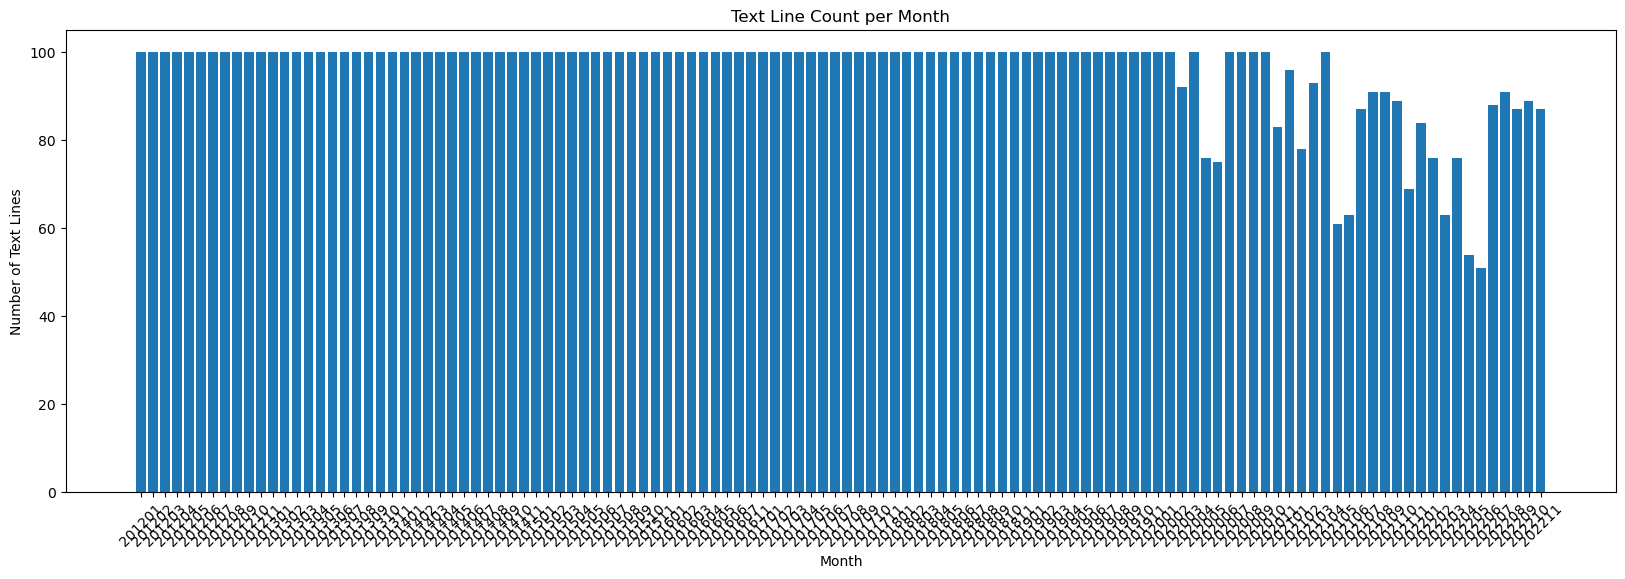

In [44]:
monthly_line_count = text_source.groupby('Cycle_month').size()

plt.figure(figsize=(20, 6))
plt.bar(monthly_line_count.index.astype(str), monthly_line_count.values)
plt.xlabel('Month')
plt.ylabel('Number of Text Lines')
plt.title('Text Line Count per Month')
plt.xticks(rotation=45)
plt.savefig('./images/analysis/text_counter.jpg')
plt.show()

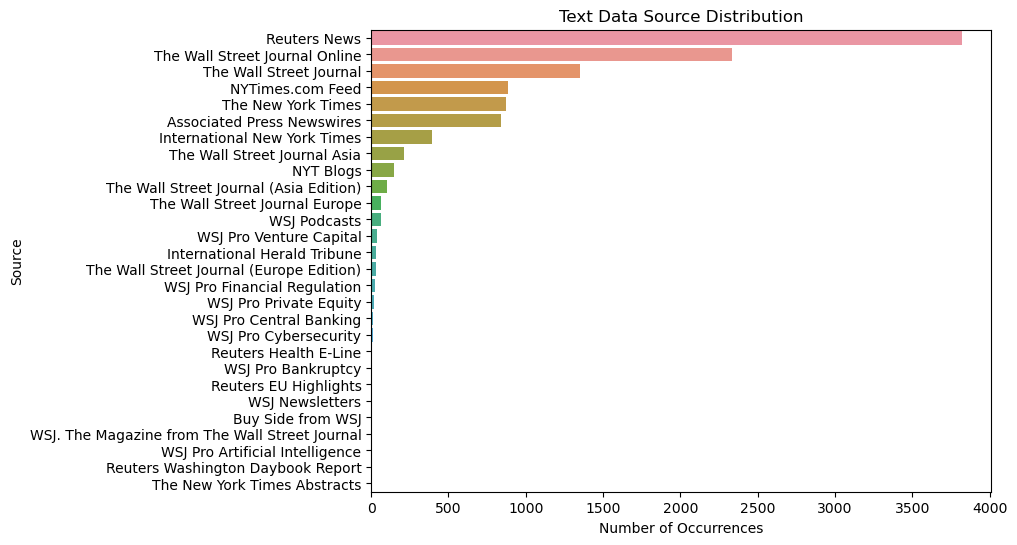

In [45]:
plt.figure(figsize=(8, 6))
sns.countplot(y='Source', data=text_source, order=text_source['Source'].value_counts().index)
plt.xlabel('Number of Occurrences')
plt.ylabel('Source')
plt.title('Text Data Source Distribution')
plt.savefig('./images/analysis/text_source.jpg')
plt.show()

## Text Analysis

In [46]:
stop_words = set(stopwords.words('english'))

### Without Stop Words

In [47]:
def get_top_words(text_series, top_n=5):
    words = nltk.word_tokenize(" ".join(text_series))
    words = [word for word in words if word.isalpha() and word not in stop_words]
    word_freq = Counter(words)
    return word_freq.most_common(top_n)

In [48]:
for name, group in text_source.groupby('Cycle_month'):
    top_headline_words = get_top_words(group['Headline'])
    top_text_words = get_top_words(group['Text'])
    print(f'{name} Cycle Month:')
    print('Top Headline Words:', top_headline_words)
    print('Top Text Words:', top_text_words)
    print('\n')

201201 Cycle Month:
Top Headline Words: [('UPDATE', 16), ('Apple', 16), ('What', 11), ('Nokia', 10), ('loss', 9)]
Top Text Words: [('said', 482), ('The', 451), ('Apple', 432), ('company', 404), ('quarter', 351)]


201202 Cycle Month:
Top Headline Words: [('UPDATE', 16), ('A', 10), ('What', 8), ('new', 7), ('look', 6)]
Top Text Words: [('The', 584), ('said', 449), ('company', 375), ('year', 358), ('Apple', 358)]


201203 Cycle Month:
Top Headline Words: [('BlackBerry', 13), ('CEO', 13), ('UPDATE', 12), ('China', 11), ('Nokia', 10)]
Top Text Words: [('said', 566), ('The', 553), ('company', 545), ('year', 380), ('RIM', 340)]


201204 Cycle Month:
Top Headline Words: [('UPDATE', 10), ('A', 8), ('Profit', 8), ('look', 7), ('selected', 7)]
Top Text Words: [('The', 473), ('said', 466), ('year', 426), ('company', 366), ('quarter', 328)]


201205 Cycle Month:
Top Headline Words: [('UPDATE', 13), ('RIM', 11), ('A', 10), ('News', 7), ('BlackBerry', 7)]
Top Text Words: [('The', 653), ('said', 525)

In [49]:
all_headline_words = pd.DataFrame()
all_text_words = pd.DataFrame()
for name, group in text_source.groupby('Cycle_month'):
    top_headline_words = get_top_words(group['Headline'])
    top_text_words = get_top_words(group['Text'])
    
    temp_headline_df = pd.DataFrame(top_headline_words, columns=['Word', 'Frequency'])
    temp_headline_df['Cycle_month'] = name
    temp_headline_df['Type'] = 'Headline'
    
    temp_text_df = pd.DataFrame(top_text_words, columns=['Word', 'Frequency'])
    temp_text_df['Cycle_month'] = name
    temp_text_df['Type'] = 'Text'
    
    all_headline_words = pd.concat([all_headline_words, temp_headline_df], ignore_index=True)
    all_text_words = pd.concat([all_text_words, temp_text_df], ignore_index=True)

all_words = pd.concat([all_headline_words, all_text_words], ignore_index=True)

In [50]:
# all_words['Cycle_month'] = all_words['Cycle_month'].astype(str)

# sns.set(style="whitegrid")


# plt.figure(figsize=(12, 6))
# sns.barplot(x='Word', y='Frequency', hue='Cycle_month', data=all_words[all_words['Type'] == 'Headline'])
# plt.title('Top Headline Words by Cycle Month')
# plt.xticks(rotation=45)
# plt.show()


### With Stop Words

In [51]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def get_top_words(text_series, top_n=5):
    words = nltk.word_tokenize(" ".join(text_series))
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]
    word_freq = Counter(words)
    return word_freq.most_common(top_n)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
display(stop_words)

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [53]:
all_headline_words = pd.DataFrame()
all_text_words = pd.DataFrame()

for name, group in text_source.groupby('Cycle_month'):
    top_headline_words = get_top_words(group['Headline'])
    top_text_words = get_top_words(group['Text'])
    
    temp_headline_df = pd.DataFrame(top_headline_words, columns=['Word', 'Frequency'])
    temp_headline_df['Cycle_month'] = name
    temp_headline_df['Type'] = 'Headline'
    
    temp_text_df = pd.DataFrame(top_text_words, columns=['Word', 'Frequency'])
    temp_text_df['Cycle_month'] = name
    temp_text_df['Type'] = 'Text'
    
    all_headline_words = pd.concat([all_headline_words, temp_headline_df], ignore_index=True)
    all_text_words = pd.concat([all_text_words, temp_text_df], ignore_index=True)

all_words = pd.concat([all_headline_words, all_text_words], ignore_index=True)

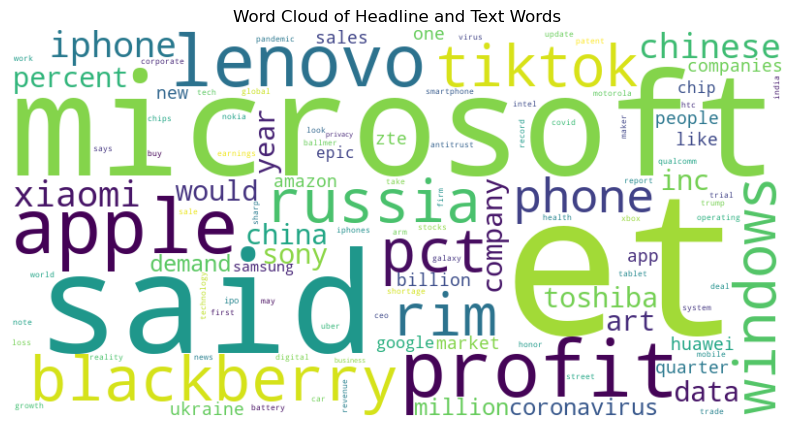

In [54]:
word_freq_dict = dict(zip(all_words['Word'], all_words['Frequency']))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Headline and Text Words')
plt.savefig('./images/analysis/wordcloud.jpg')
plt.show()

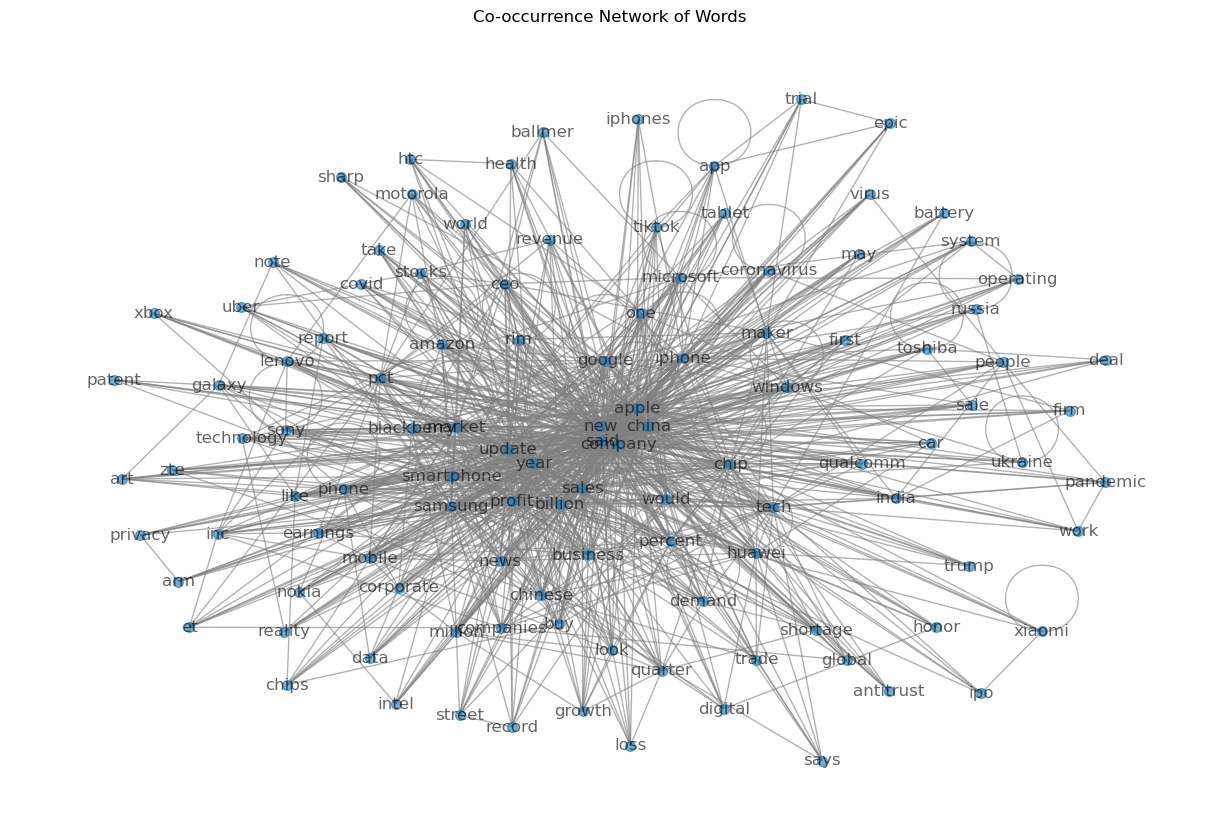

In [55]:
G = nx.Graph()

for word in all_words['Word']:
    G.add_node(word)

for word_list in all_words.groupby('Cycle_month')['Word']:
    for word1, word2 in combinations(word_list[1], 2):
        if not G.has_edge(word1, word2):
            G.add_edge(word1, word2)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, node_size=50, with_labels=True, alpha=0.6, edge_color='gray')
plt.title('Co-occurrence Network of Words')
plt.savefig('./images/analysis/wordconnect_graph.jpg')
plt.show()